# Snake

In [1]:
from environments import *
from IPython.display import clear_output
from  tqdm import trange
import matplotlib.pyplot as plt
import os
from replay_memory import *
from models import *
import json
import random
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
LOAD_FROM_MEMORY = False

## Environment definition

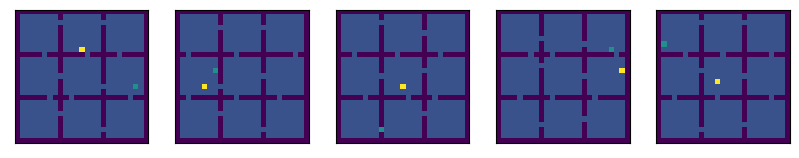

In [3]:
%matplotlib inline
def get_env(n=1000):
    return Walls25x25SnakeEnvironment(n)
env_ = get_env()
GAMMA = .9
ITERATIONS = 100000
EPSILON = 0.1
LAMBDA_VALUE = 0.
LAMBDA_AGENT = 0.
RESET_EVERY_N = 100
# 10 random iterations, 100 elements from each of them
replay_memory = ReplayMemoryFast(1000, 10, 100)
#  ALPHA = 0.1

fig,axs=plt.subplots(1,min(len(env_.boards), 5), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board, origin="lower")

## Demo

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
demo_env = get_env(1000)
def animate(_):
    probs = tf.convert_to_tensor([[.25]*4]*demo_env.n_boards)
    actions = tf.random.categorical(tf.math.log(probs),1)
    demo_env.move(actions)
    for board, image in zip(demo_env.boards[:len(images)], images):
        image.set_data(board)
    return images

In [9]:
fig, axs = plt.subplots(1,4, figsize=(10,3))
images = []
for b, ax in zip(demo_env.boards, axs.flatten()):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    images.append(ax.imshow(b, origin="lower"))
anim = FuncAnimation(fig, animate, interval=30)

<IPython.core.display.Javascript object>

## Model

In [4]:
class EpsGreedyPolicy:
    def __init__(self, exp_iter=ITERATIONS*4/5):
        self.iter = 0
        self.exp_iter = exp_iter
    def sample(self, q_values):
        eps = max(0.75-self.iter / self.exp_iter, 0.1)
        self.iter += 1
        probs = np.ones_like(q_values) * eps/3.
        np.put_along_axis(probs, np.argmax(q_values, axis=-1)[..., None], 1-eps, axis=1)
        probs = tf.linalg.normalize(probs, ord=1, axis=-1)[0]
        return tf.random.categorical(
            np.log(probs), 1
        ).numpy()

In [5]:
MODELS_PREFIX = f"models/{type(env_).__name__}/{env_.board_size}x{env_.board_size}"
os.makedirs(MODELS_PREFIX, exist_ok=True)

In [6]:
qfunction, avg_rewards = load_models(env_, folder_name=MODELS_PREFIX if LOAD_FROM_MEMORY else None)

Metal device set to: Apple M1 Max


2023-01-16 19:02:26.044461: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-16 19:02:26.044607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
qtarget = tf.keras.models.clone_model(
    qfunction
)

## Training

In [52]:
policy = EpsGreedyPolicy()

In [53]:
optimizer = K.optimizers.Adam(1e-4)

In [54]:
loss_f = tf.keras.losses.MeanSquaredError()

@tf.function
def train_step(samples, qfunction, qtarget):
    with tf.GradientTape(persistent=True) as tape:
        losses = []
        for observation, action, reward, new_observation in samples:
            indexes = tf.range(tf.shape(action)[0], dtype=tf.int64)[..., None]
            q_estimate = qfunction(observation)
            action = tf.concat((indexes, action), axis=-1)
            q_obs = tf.gather_nd(q_estimate, action)[...,None]
            q_target = tf.stop_gradient(reward + GAMMA * tf.reduce_max(qtarget(new_observation), axis=-1)[...,None])
            losses.append(loss_f(q_target, q_obs))
        loss = tf.reduce_mean(losses)
    gradient_q = tape.gradient(loss, qfunction.trainable_weights)
    optimizer.apply_gradients(zip(gradient_q, qfunction.trainable_weights))
    return loss

In [55]:
losses = []
avg_rewards = []

In [56]:
history = []

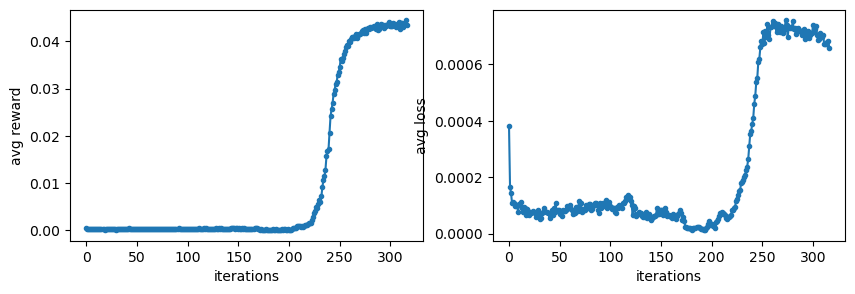

  1%|          | 379/36792 [01:23<2:13:41,  4.54it/s] 


KeyboardInterrupt: 

In [58]:
%matplotlib inline
for iteration in trange(63208+379, ITERATIONS):
    if iteration % RESET_EVERY_N == 0:
        qtarget.set_weights(qfunction.get_weights())

    state = env_.to_state()
    actions = policy.sample(qfunction(env_.to_state()))
    rewards = env_.move(actions)
    new_state = env_.to_state()
    replay_memory.store(state, actions, rewards, new_state)
    samples = replay_memory.sample()
    history.append(env_.boards[0].tolist())

    if len(samples) >= replay_memory.minibatch_size:
        avg_rewards.append(np.mean(rewards == env_.FRUIT_REWARD))
        loss = train_step(samples, qfunction, qtarget)
        losses.append(
            loss
        )
    N = 200
    if len(avg_rewards) % N == 0 and len(avg_rewards) > 0:
        # clear output
        clear_output(wait=True)
        points_r = np.array(avg_rewards).reshape((-1, N)).mean(axis=-1)
        points_t = np.array(losses).reshape((-1, N)).mean(axis=-1)
        fig, axs = plt.subplots(1,2, figsize=(10,3))
        axs[0].plot(points_r, marker=".")
        axs[0].set_xlabel("iterations")
        axs[0].set_ylabel("avg reward")
        axs[1].plot(points_t, marker=".")
        axs[1].set_xlabel("iterations")
        axs[1].set_ylabel("avg loss")
        plt.show()
        # save
        with open(f"{MODELS_PREFIX}/training.txt", "w+") as file:
            json.dump(np.array(avg_rewards).tolist(), file)
        with open(f"{MODELS_PREFIX}/history.txt", "w+") as file:
            json.dump(history, file)
        qfunction.save_weights(f"{MODELS_PREFIX}/agent")

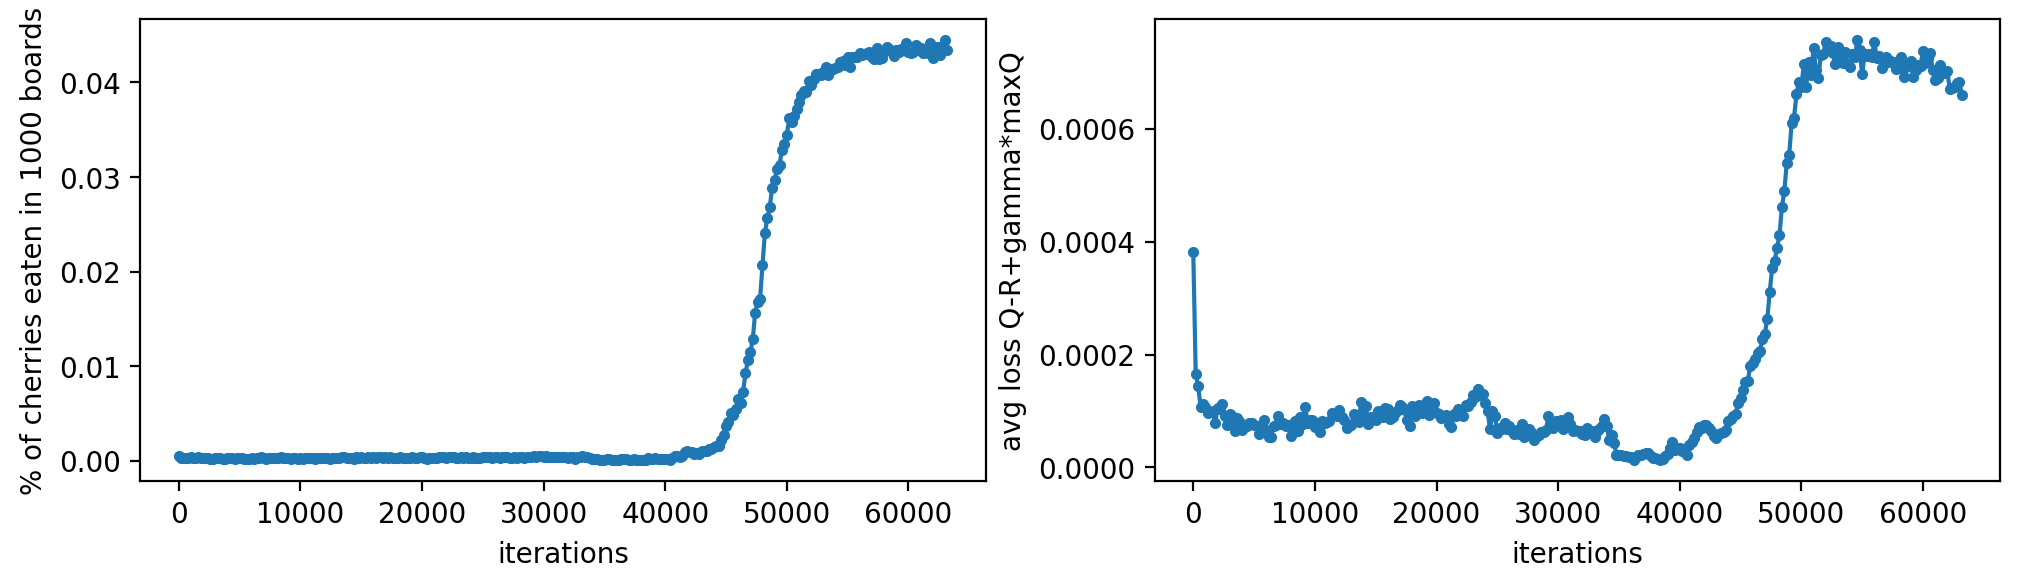

In [59]:
N=200
avg_rewards = avg_rewards[:len(avg_rewards)//N*N]
losses = losses[:len(losses)//N*N]
points_r = np.array(avg_rewards).reshape((-1, N)).mean(axis=-1)
points_t = np.array(losses).reshape((-1, N)).mean(axis=-1)
fig, axs = plt.subplots(1,2, figsize=(12,3), dpi=200)
plt.rcParams['text.usetex'] = False
x = np.arange(len(points_r)) * N
axs[0].plot(x, points_r, marker=".")
axs[0].set_xlabel("iterations")
axs[0].set_ylabel("% of cherries eaten in 1000 boards")
axs[1].plot(x, points_t, marker=".")
axs[1].set_xlabel("iterations")
axs[1].set_ylabel("avg loss Q-R+gamma*maxQ")
plt.show()

 ### Random policy reward

In [60]:
random_env = get_env(1000)
random_rewards = []

for _ in trange(1000):
    #sample actions
    actions =  tf.random.categorical(tf.math.log(tf.convert_to_tensor([[.25]*4]*random_env.n_boards)), 1, dtype=tf.int32)
    # MDP update
    rewards = random_env.move(actions)
    random_rewards.append(np.mean(rewards == env_.FRUIT_REWARD))

100%|██████████| 1000/1000 [00:28<00:00, 34.73it/s]


## Training evaluation

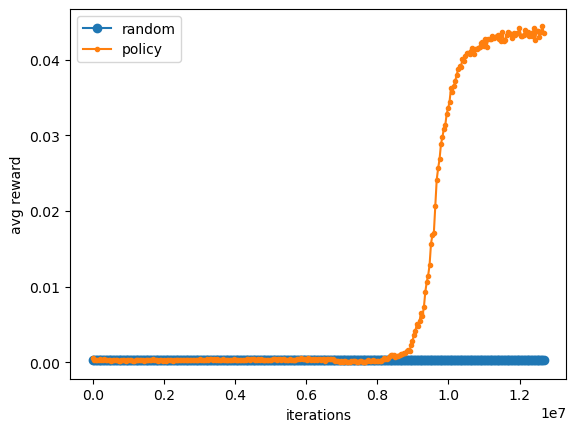

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
CHUNK_SIZE = 200
N = len(avg_rewards)//CHUNK_SIZE*CHUNK_SIZE
x = np.linspace(0,CHUNK_SIZE*N, N//CHUNK_SIZE)
plt.plot(x, np.array(random_rewards[700:]).mean(axis=-1).repeat(N//CHUNK_SIZE), marker="o")
points = np.array(avg_rewards)[:N].reshape((-1, CHUNK_SIZE)).mean(axis=-1)
plt.plot(x, points, marker=".")
_ = plt.xlabel("iterations")
_ = plt.ylabel("avg reward")
plt.legend(["random", "policy"])

 ## Test (graphical simulation)

In [106]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [107]:
test_env = get_env(3)

In [108]:
def animate(_):
    actions = policy.sample(qfunction(test_env.to_state()))
    test_env.move(actions)
    for board, image in zip(test_env.boards, images):
        image.set_data(board)
    return images

In [109]:
# first three are policy guided, the fourth is random, to give a comparison
fig, axs = plt.subplots(1,3, figsize=(10,5))
images = []
for b, ax in zip(test_env.boards, axs.flatten()):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    images.append(ax.imshow(b, origin="lower"))
anim = FuncAnimation(fig, animate, interval=30)

<IPython.core.display.Javascript object>